# Numerical simulation of FAST applied to a the fine flakes image at various noise levels

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import fast.s26_analysis.utils as utils 
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import renormalize

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import skimage
from tqdm.notebook import tqdm
import tifffile as tif
import joblib

In [3]:

frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype('bool'))

In [37]:
norm_counts = joblib.load('norm_counts.joblib')

In [38]:
diff_data = joblib.load('diffs_roi_for_noisy_fast_sims.joblib')

In [40]:
background_counts = 0.0093

In [41]:
background_counts

0.0093

In [43]:
diff_data_roi.shape

(40, 200, 30, 30)

### plotting the data with no additional nosie

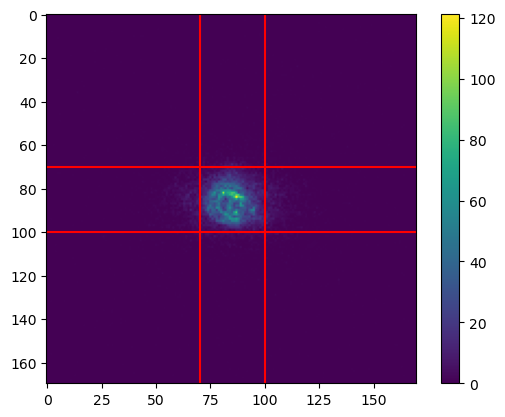

In [44]:
plt.figure()
plt.imshow(diff_data[32,50])
plt.axvline(85-15, color='red')
plt.axvline(85+15, color='red')

plt.axhline(85-15, color='red')
plt.axhline(85+15, color='red')
plt.colorbar()
plt.show()

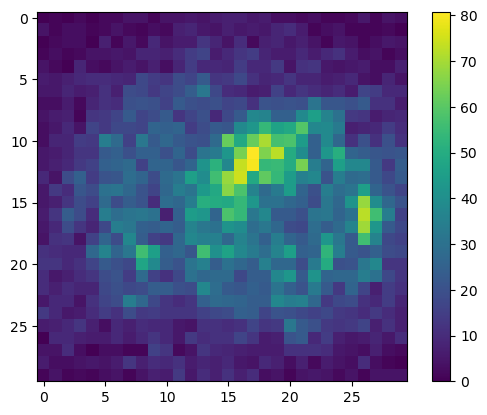

In [45]:
plt.figure()
plt.imshow(diff_data_roi[0,0])
plt.colorbar()
plt.show()

In [46]:
img_true = renormalize(diff_data_roi.sum(axis=(2,3)))

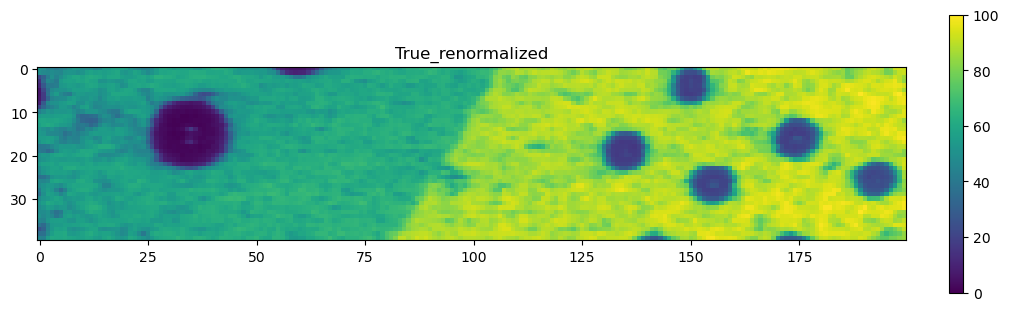

In [47]:
plt.figure(figsize=[10,3], constrained_layout=True)
plt.imshow(img_true)
plt.title(f'True_renormalized')
plt.colorbar()
plt.show()

In [48]:
for pow_n in range(1, 4):
    fac = 10 ** pow_n
    dat_new = diff_data_roi / fac
    dat_new_noisy = np.random.poisson(dat_new + background_counts)
    dat_nonzero = dat_new_noisy[dat_new_noisy > 0]
    print(np.mean(dat_new_noisy**0.5), np.mean(dat_new) / np.mean(dat_new**0.5))

1.1888553101830606 1.6456612992836763
0.20774757993950937 0.5204037962928437
0.03128899800194987 0.1645661299283674


Max count is 23.845938246778907
Max noisy count is 31


/tmp/ipykernel_724528/3529854507.py:23: RuntimeWarning: invalid value encountered in sqrt
  snrs2[fac] = np.mean(dat_new_noisy / np.sqrt((dat_new - dat_new_noisy) + background_counts))


SNR is 1.9875971576216513 nan


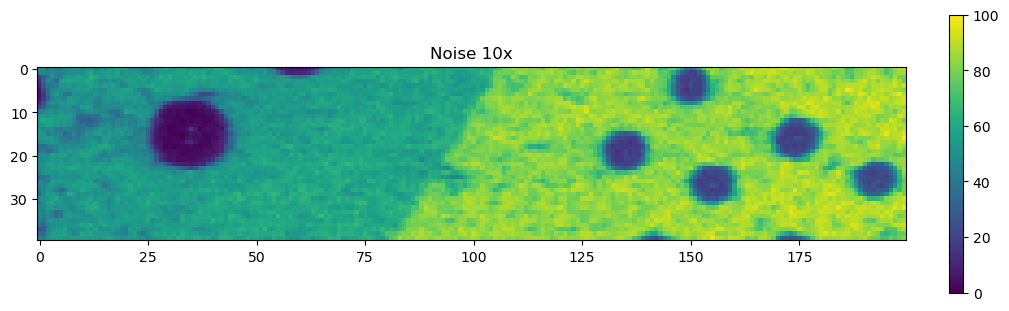

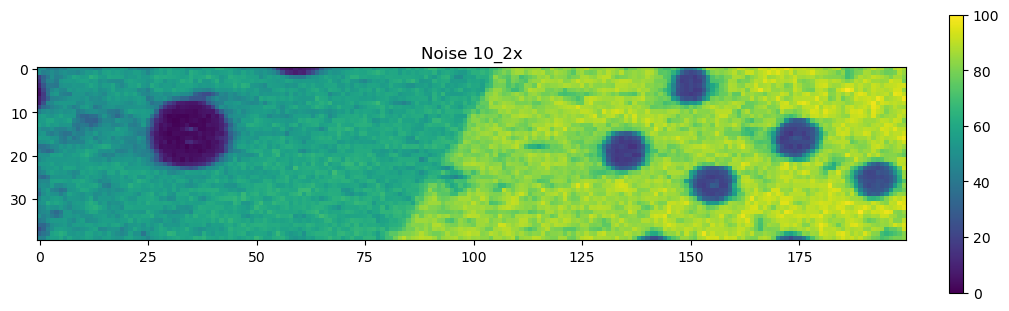

Max count is 2.384593824677891
Max noisy count is 8
SNR is 0.6175453141306407 nan


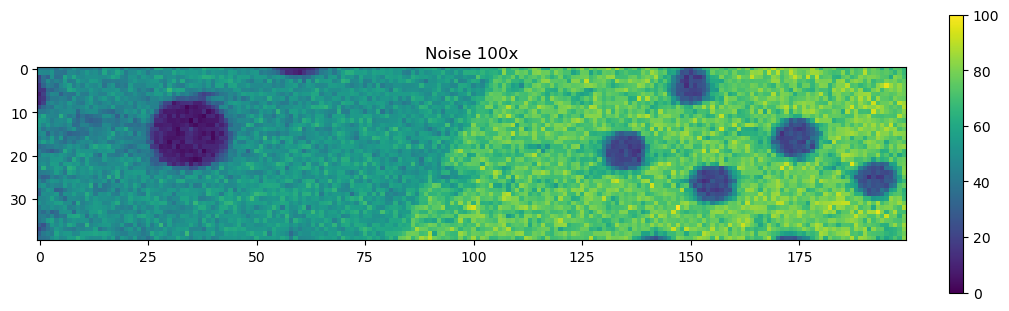

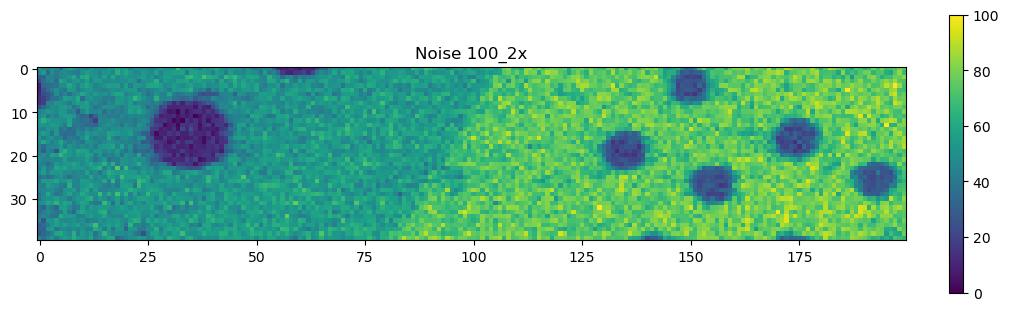

Max count is 0.23845938246778908
Max noisy count is 4
SNR is 0.16656106294923345 nan


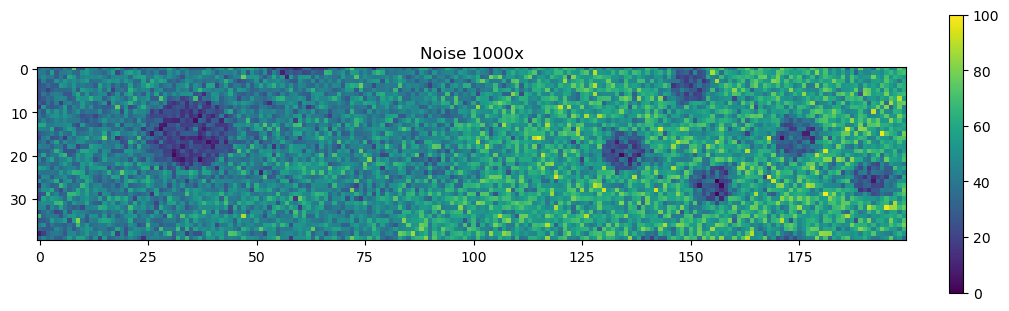

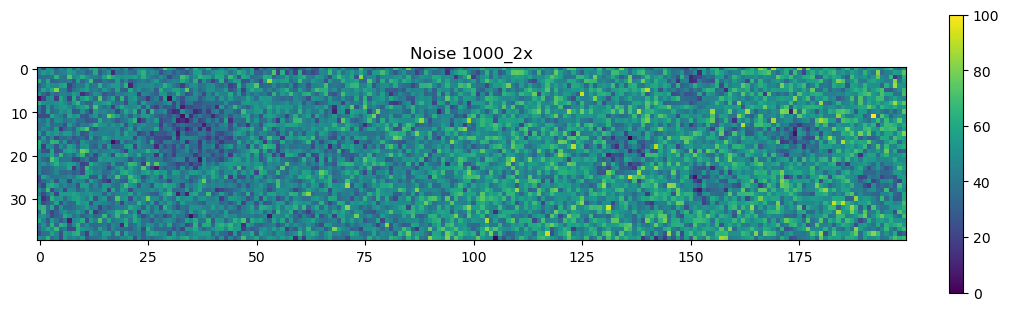

In [77]:
# Noise levels [4, 16, 64, 256, 1024]
snrs = {}
snrs2 = {}
diff_sums_noise = {}
diff_sums_norm_noise = {}
full_diffs_noise = {}

for pow_n in range(1, 4):
    fac = 10 ** pow_n
    dat_new = diff_data_roi / fac
    print('Max count is', dat_new.max())
    
    dat_new_noisy = np.random.poisson(dat_new + background_counts) 
    dat_new_noisy_2 = np.random.poisson(dat_new + background_counts * 10)
    
    fac2 = f'{fac}_2'
    full_diffs_noise[fac] = dat_new_noisy
    full_diffs_noise[fac2] = dat_new_noisy_2
    
    print('Max noisy count is', dat_new_noisy.max())
    
    snrs[fac] = (np.sum(dat_new**2))**0.5/ (np.sum((dat_new - dat_new_noisy)**2 + background_counts**2))**0.5
    snrs2[fac] = np.mean(dat_new_noisy / np.sqrt((dat_new - dat_new_noisy) + background_counts))
    
    snrs[fac2] = (np.sum(dat_new**2))**0.5/ (np.sum((dat_new - dat_new_noisy_2)**2))**0.5
    snrs2[fac2] = np.mean(dat_new_noisy**0.5)
    
    print('SNR is', snrs[fac], snrs2[fac])
    
    diff_sums_noise[fac] = renormalize(dat_new_noisy.sum(axis=(2,3)), min_value=0, max_value=100)
    #diff_sums_norm_noise[fac] = diff_sums_noise[fac] / (norm_counts / fac + background_counts * 50 * 50)
    
    diff_sums_noise[fac2] = renormalize(dat_new_noisy_2.sum(axis=(2,3)), min_value=0, max_value=100)
    #diff_sums_norm_noise[fac2] = diff_sums_noise[fac2] / (norm_counts / fac + background_counts * 10 * 50 * 50)

    plt.figure(figsize=[10,3], constrained_layout=True)
    plt.imshow(diff_sums_noise[fac])
    plt.title(f'Noise {fac}x')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=[10,3], constrained_layout=True)
    plt.imshow(diff_sums_noise[fac2])
    plt.title(f'Noise {fac2}x')
    plt.colorbar()
    plt.show()

### Simulating the FAST procedure

In [78]:
# Get a 1% measurement mask
init_pattern = gcn(*diff_sums_noise[10].T.shape, 0.01)

Initial ratio is 0.01


Text(0.5, 1.0, 'Initial scan pattern')

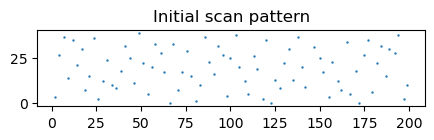

In [79]:
plt.figure(figsize=[5, 5])
plt.scatter(init_pattern[:,1], init_pattern[:,0], s=0.5)
#plt.vlines([0, 128], ymin=0, ymax=128, color='magenta')
#plt.hlines([0, 128], xmin=0, xmax=128, color='magenta')
plt.gca().set_aspect('equal')
plt.title('Initial scan pattern')

In [80]:
model  = Path.home() / 'code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl'

In [81]:
masks_all = {}
recons_fast_all = {}
ratios_all = {}
tot_erds_all = {}

for noise in diff_sums_noise:
    sample = diff_sums_noise[noise]
    sample_this = utils.create_experiment_sample(numx=sample.shape[1], numy=sample.shape[0],
                                        inner_batch_size=50,
                                        initial_idxs=init_pattern,
                                        erd_model_file_path=model)
    masks_this = []
    recons_fast_this = []
    ratios_this = []
    tot_erds_this = []
    
    count = 0
    new_idxs = init_pattern

    n_scan_points = int(0.8 * sample.size)
    pbar = tqdm(total=n_scan_points, desc='Scanned points')
    # Continue until we measure 40% of the points.
    while sample_this.mask.sum() < n_scan_points:
        # Supply the measurement values.
        sample_this.measurement_interface.finalize_external_measurement(sample[new_idxs[:,0], new_idxs[:,1]])

        # Supply in measurement positions
        sample_this.perform_measurements(new_idxs)

        # Use the measurement values to reconstruct the sample and calculate the ERDs
        sample_this.reconstruct_and_compute_erd()

        # Compute new positions.
        new_idxs = sample_this.find_new_measurement_idxs()[:50]

        ratio = sample_this.ratio_measured
        ratios_this.append(ratio)
        tot_erds_this.append(sample_this.ERD.sum())
        recons_fast_this.append(sample_this.recon_image.copy())
        masks_this.append(sample_this.mask.copy())
        pbar.update(int(sample_this.mask.sum() - pbar.n))
        
    masks_all[noise] = masks_this
    recons_fast_all[noise] = recons_fast_this
    ratios_all[noise] = ratios_this
    tot_erds_all[noise] = tot_erds_this
    

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Scanned points:   0%|          | 0/6400 [00:00<?, ?it/s]

In [82]:
data_all = {}
skip = 2
for n1, noise_level in enumerate(masks_all):
    _recons = []
    _masks = []
    _recons_bh = []
    _psnrs = []
    _ssims = []
    _rmses = []
    _ratios = []
    for n2, scan_ratio in enumerate(ratios_all[noise_level]):
        if n2 % skip != 0:
            continue
        r1 = recons_fast_all[noise_level][n2]
        m1 = masks_all[noise_level][n2]
        
        #r2 = r1
        r2 = frbh(r1, m1)
        _ssims.append(skimage.metrics.structural_similarity(img_true, r2))
        _psnrs.append(skimage.metrics.peak_signal_noise_ratio(img_true, r2, data_range=100))
        _rmses.append(skimage.metrics.normalized_root_mse(img_true, r2))

        _recons.append(r1)
        _masks.append(m1)
        _recons_bh.append(r2)
        _ratios.append(scan_ratio)
        
    data_all[noise_level] = {'recons': _recons, 
                                 'masks': _masks,
                                 'recons_bh': _recons_bh,
                                 'ssims': _ssims,
                                 'psnrs': _psnrs,
                                 'rmses': _rmses,
                                 'scan_ratios': _ratios}

In [83]:
save_dir = Path.cwd()
#save_dir.mkdir(exist_ok=True)
save_fname = save_dir / 'data_all.joblib'

In [84]:
joblib.dump(data_all, save_fname, compress=4)

['/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/noise_analysis/data_all.joblib']

In [85]:
!du -hsc $save_fname

33M	/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/noise_analysis/data_all.joblib
33M	total


In [86]:
markers = [".", 'o', 'D', '<', 's', 'P', 'X', 'D', 9, 10, 'd']
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

     ('densely dotted',        (0, (1, 1))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1))),
     ('dotted',                (0, (1,1)))]

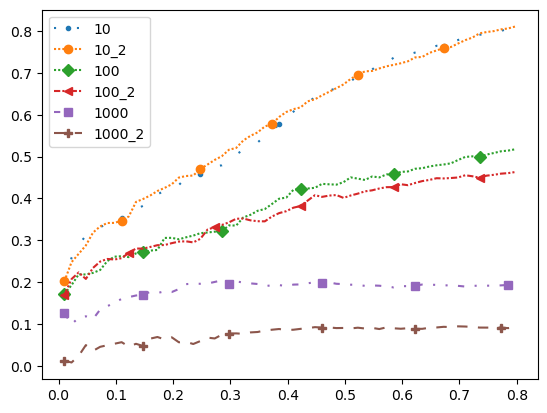

In [87]:
for ix, label in enumerate(data_all):
    
    plt.plot(data_all[label]['scan_ratios'], data_all[label]['ssims'],
             label=label, markevery=0.15, marker=markers[ix], ls=linestyle_tuple[ix][1])
plt.legend(loc='best')
#plt.xlim([0.01, 0.3])
plt.show()

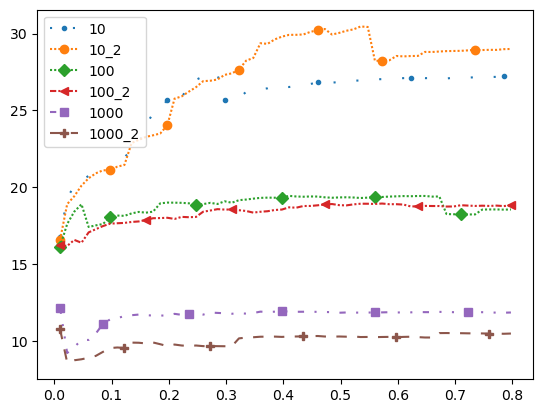

In [88]:
for ix, label in enumerate(data_all):
    
    plt.plot(data_all[label]['scan_ratios'], data_all[label]['psnrs'],
             label=label, markevery=0.15, marker=markers[ix], ls=linestyle_tuple[ix][1])
plt.legend(loc='best')
#plt.xlim([0.01, 0.3])
plt.show()

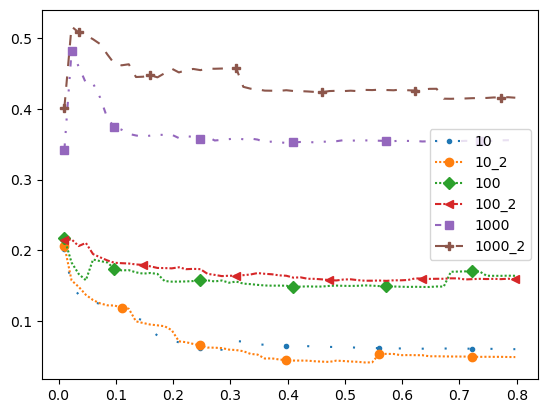

In [89]:
for ix, label in enumerate(data_all):
    
    plt.plot(data_all[label]['scan_ratios'], data_all[label]['rmses'],
             label=label, markevery=0.15, marker=markers[ix], ls=linestyle_tuple[ix][1])
plt.legend(loc='best')
#plt.xlim([0.01, 0.3])
plt.show()

In [90]:
ratios_to_plot = [0.05, 0.15, 0.2]
idxs_to_plot = [np.argmin(np.abs(np.array(data_all[10]['scan_ratios']) - r)) for r in ratios_to_plot]

In [91]:
idxs_to_plot

[3, 11, 15]

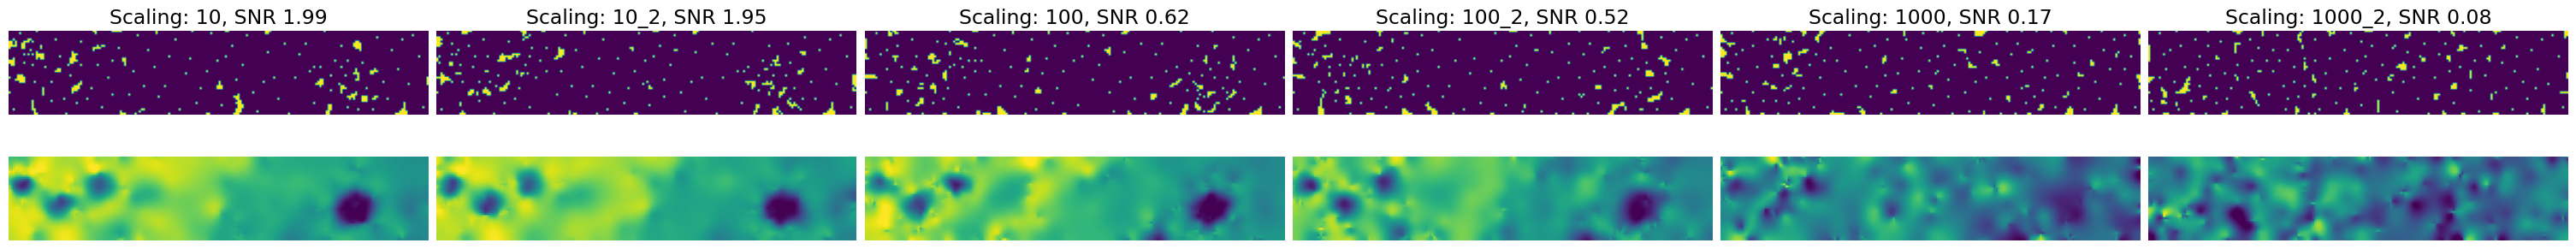

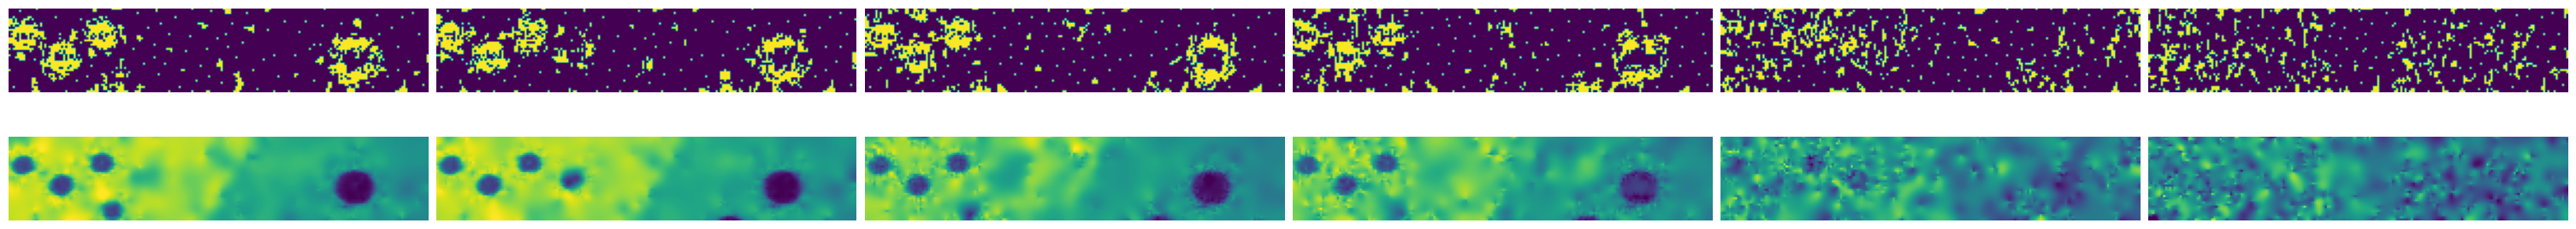

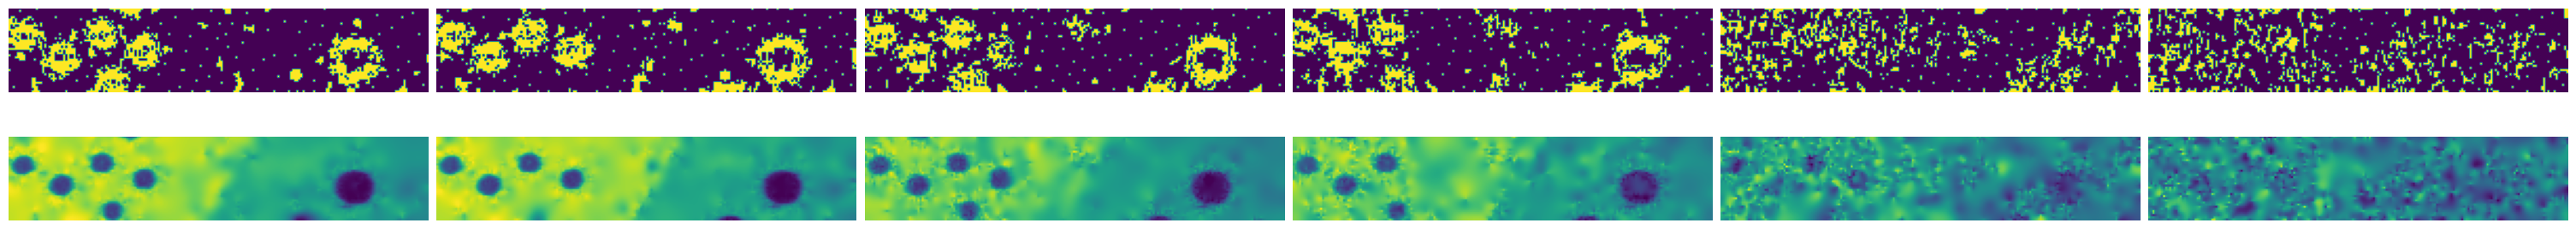

In [92]:
for ix, sr in zip(idxs_to_plot, ratios_to_plot):
    fig, axs = plt.subplots(2, 6, figsize=[30,3], constrained_layout=True)
    
    iy = 0
    for label in data_all:
        if label == 1: continue
        
        axs[0, iy].imshow(data_all[label]['masks'][ix][::-1, ::-1])    
        if ix==3:
            axs[0, iy].set_title(f'Scaling: {label}, SNR {snrs[label]:3.2f}', size=17)
        axs[0, iy].axis('off')
        
        axs[1, iy].imshow(data_all[label]['recons_bh'][ix][::-1, ::-1])
        axs[1, iy].axis('off')
        iy += 1
    #fig.suptitle(f"Scan coverage {sr * 100:4.2f}%", size=17)
    #plt.tight_layout()
    plt.show()

### Plotting sample diffraction patterns

In [93]:
diffs_to_plot = np.random.randint(0, diff_data.shape[0] * diff_data.shape[1],size=5)

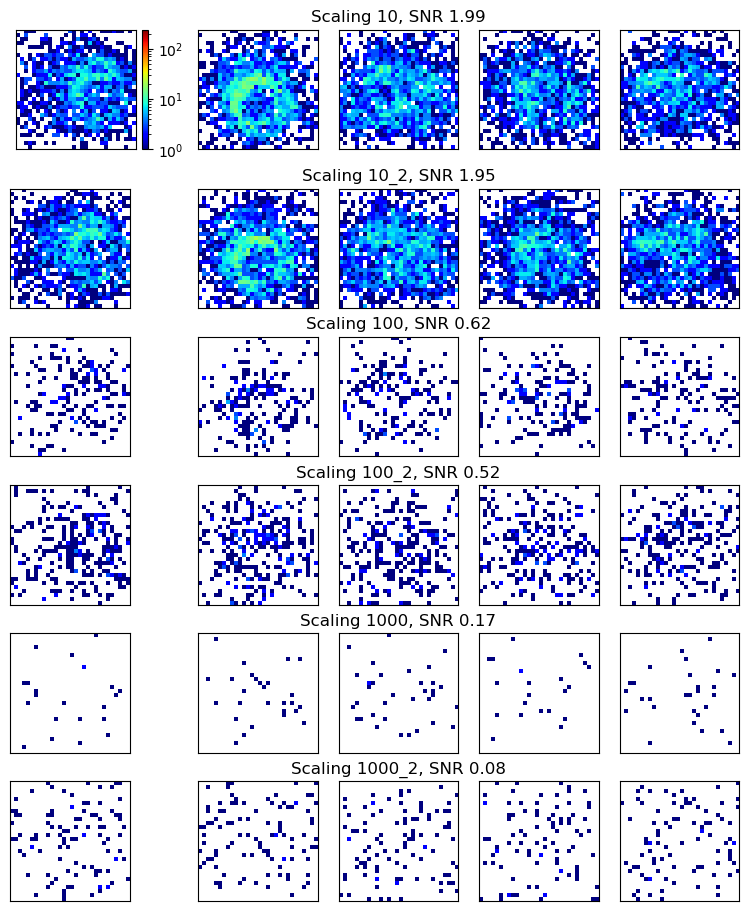

In [94]:
fig, axs = plt.subplots(6, 5, figsize=[7.5,1.5 * 6], constrained_layout=True)
for ix, scaling in enumerate(full_diffs_noise):
    for iy, nd in enumerate(diffs_to_plot):
        plt.subplot(6, 5, ix * 5 + iy + 1)
        
        cmap = plt.cm.jet.copy()
        cmap.set_bad('white')
        plt.imshow(full_diffs_noise[scaling][nd // 200][nd % 200], norm=mpl.colors.LogNorm(vmax=diff_data_roi.max()), cmap=cmap)
        if ix==0 and iy==0:
            plt.colorbar()
        ax = plt.gca()
        #axs[ix, iy].axis('off')
    #fig.suptitle(f"Scaling {scaling}, SNR {snrs[scaling]:3.2f}", size=14)
    #plt.tight_layout()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
        if iy==2:
            ax.set_title(f"Scaling {scaling}, SNR {snrs[scaling]:3.2f}", size=12)
        
plt.show()

In [54]:
mpl.colors.LogNorm??

Init signature: mpl.colors.LogNorm(vmin=None, vmax=None, clip=False)
Docstring:      Normalize a given value to the 0-1 range on a log scale.
File:           ~/miniforge3/envs/fast/lib/python3.10/site-packages/matplotlib/colors.py
Type:           type
Subclasses:     